In [1]:
import pandas as pd
import numpy as np
import imageio.v3 as iio
import os

import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt

import time

## Load Data

In [2]:
img = iio.imread("COVID-19_Lung_CT_Scans/COVID-19/COVID-19_0001.png")
img.min(), img.max()

(0, 255)

In [3]:
# Creating the annotations_file
filenames = os.listdir('COVID-19_Lung_CT_Scans/COVID-19/')

arr = []
for file in filenames:
    if '.png' not in file: continue
    label = 0 if 'Non' in file else 1
    arr.append([file, label])

df = pd.DataFrame(arr)
print(df.shape)
df.to_csv('COVID-19_Lung_CT_Scans/annotations_file.csv', index=False, header=False)

(8439, 2)


In [4]:
class CovidCTDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.img_labels)
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [5]:
data = CovidCTDataset(annotations_file='COVID-19_Lung_CT_Scans/annotations_file.csv', 
                      img_dir='COVID-19_Lung_CT_Scans/COVID-19/')

In [6]:
train_set, test_set = random_split(data, [0.8, 0.2])

In [7]:
trainloader = DataLoader(train_set, batch_size=4, shuffle=True)
testloader = DataLoader(test_set, batch_size=4, shuffle=False)

In [8]:
len(trainloader.dataset), len(testloader.dataset)

(6751, 1687)

In [9]:
classes = ('Non-COVID-19', 'COVID-19')

torch.Size([4, 1, 512, 512])


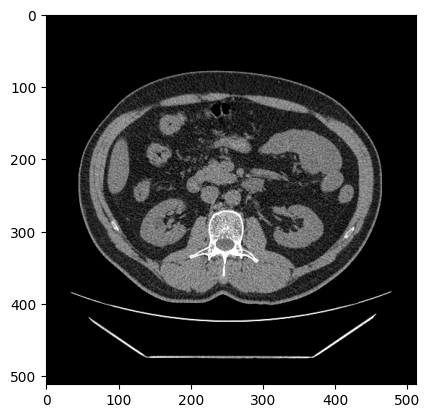

Label: COVID-19


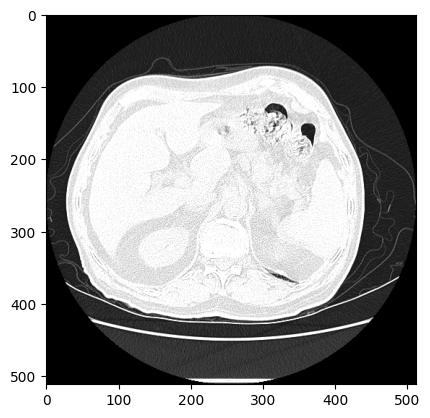

Label: COVID-19


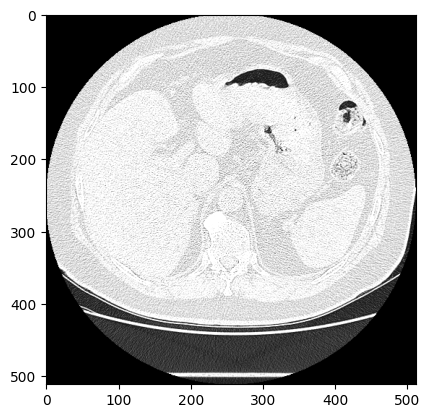

Label: COVID-19


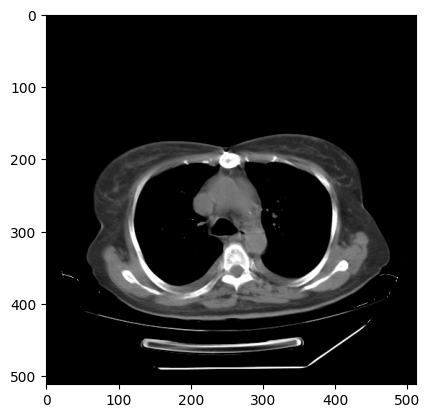

Label: Non-COVID-19


In [10]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)
for i in range(4):
    img = images[i].squeeze()
    plt.imshow(img, cmap="gray")
    plt.show()
    print(f"Label: {classes[labels[i]]}")

## Train Model

In [17]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 125 * 125, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        embedding = x.clone()
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x, embedding

net = Net()

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
num_epochs = 5
train_loss = []

In [ ]:
start = time.time()
for epoch in range(num_epochs):
    epoch_start = time.time()
    running_loss = 0.0
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.float()
        optimizer.zero_grad()

        outputs, embeddings = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_loss.append(epoch_loss / 6751)
    print(f'{epoch + 1} loss: {epoch_loss / 6751:.3f} time to train: {time.time() - epoch_start}')

print('Finished Training')
print('total time to train', time.time() - start)

In [ ]:
epochs = range(1, num_epochs + 1)

plt.plot(epochs, train_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()